# PyTorch with The Fashion MINST Dataset (Simple Project)

This notebook contains the steps for building deep neural network using PyTorch and the fashion Minst dataset where it takes an image of clothes as input and predict its class. Then, it shows the impacts of varying the hyperparameters on the accuracy of the prediction model.

#####  1. The First Training 
  - Import The Relevant Packages
  - Download and Prepare The Dataset
  - Build a Class to Fetch The Dataset
  - Define The Model, Loss Function, and Optimizer
  - Define a Training Function
  - Define an Evaluation Funtion
  - Train the Network
  - Display the Variation of the Training Loss and Accuracy
  - Results and Conclusion

## 1. The First Training

### 1.1 Import The Relevant Packages

In [3]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Train on cuda if GPU is available

### 1.2 Download and Prepare The Dataset

In [4]:
from torchvision import datasets
data_folder = "Datasets"                         #can be any directory to download the dataset
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [5]:
train_images = fmnist.data                                #training images 
train_targets = fmnist.targets                            #images labels (classes)

In [6]:
print(f"Number of training images {train_images.shape[0]}")
print(f"Number of classess {len(train_targets.unique())}")
print(f"The classess {fmnist.classes}")

Number of training images 60000
Number of classess 10
The classess ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


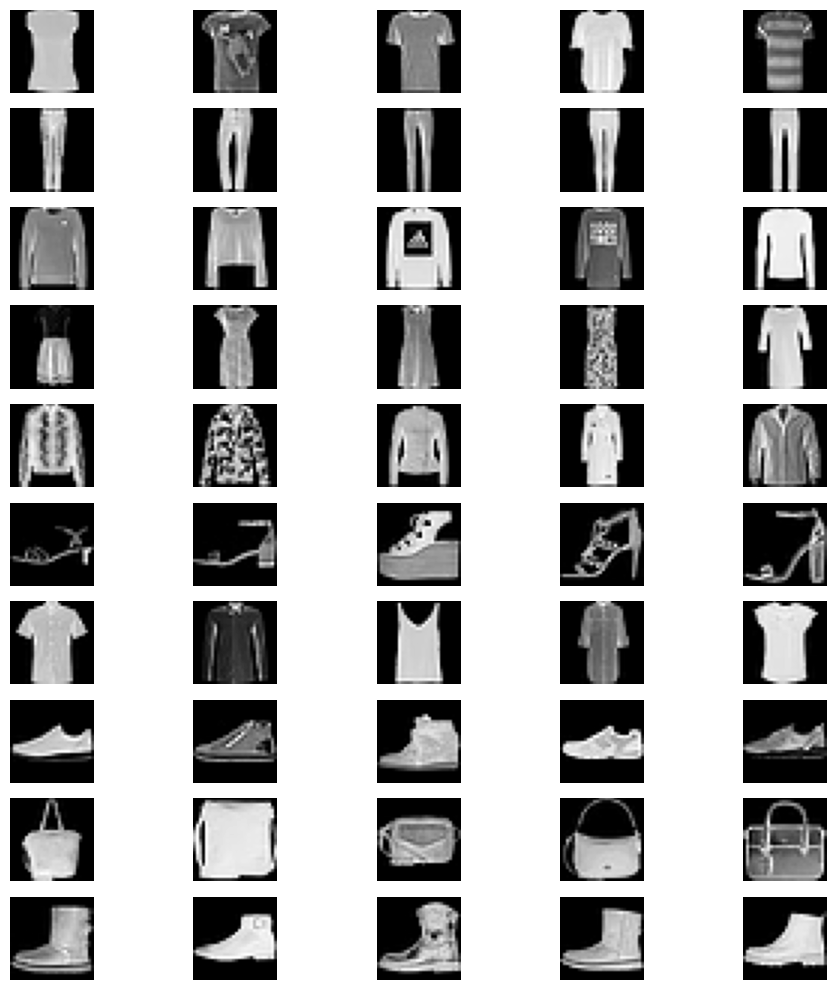

In [7]:
#Create a plot of 10*5 grid where each row belongs to a class to visualize the dataset
row,col = len(train_targets.unique()) , 5
fig, ax = plt.subplots(row,col, figsize = (10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_targets == label_class)[0]
    
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x= train_images[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

### 1.3 Build a Class to Fetch The Dataset

In [6]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x= x.float()                #convert the images to a float point numbers
        x = x.view(-1,28*28)        #flatten each image
        self.x , self.y = x,y
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        x,y = self.x[index], self.y[index]
        return x.to(device), y.to(device)       #resgister the input and the output data to the device "cuda" to train on GPU

In [7]:
train_data = FMNISTDataset(train_images,train_targets) 
#use Dataloader to sample 32 data points randomly for each batch size
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True) 

### 1.4 Define The Model, Loss Function, and Optimizer

In [62]:
#Create a model with one hidden layer (1000 neurons) and the output is a 10-neuron layer to predict the 10 classess
def build_model(optimizer = SGD, lr = 1e-2 ):
    
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000,10)
                         ).to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr = lr)   #initialize the learning rate to 0.01
    
    return model , loss_function, optimizer


### 1.5 Define a Training Function

In [9]:
def train_batch(input_batch, targets, model, loss_function, optimizer):
    model.train()                                        
    predictions = model(input_batch)                     #perfom forward propagation
    batch_loss = loss_function(predictions,targets)      #compute the loss value 
    batch_loss.backward()                                #perfom backward propagation
    optimizer.step()                                     #calculate new weights
    optimizer.zero_grad()                                #flush the gradients for next batch of calculations
    
    return batch_loss.item()                             #return the loss value
      

### 1.6 Define an Evaluation Funtion 

In [10]:
@torch.no_grad()                       #disable the gradients calculation
def get_accuracy(input_batch, targets, model):
    model.eval()
    predictions = model(input_batch)              #perfom forward propagation
    max_values, argmaxes = predictions.max(-1)    #get argmax index for each row
    is_correct = argmaxes ==targets               #compare argmax with tragets to check that each row predicts correctly
    
    return is_correct.cpu().numpy().tolist()      #return the result,register it to the cpu, and convert it to numpy array

### 1.7 Train the Network

In [11]:
model,loss_function, optimizer = build_model(optimizer=SGD,lr=1e-2)
def train(epoch_number):
    losses, accuracies = [], []                      # define lists to contain the loss and accuracy values of each epoch
    for epoch in range (epoch_number):               #define the number of the epochs
        print(f"Epoch: {epoch+1}")
        batch_losses, batch_accuracies = [],[]       #define lists to contain the loss and accuracy values of each batch

        for batch in (iter(train_data_loader)):      #create batches of training data by iterating thorugh data loader
            input_batch, targets = batch                     #unpack the batch 
            batch_loss = train_batch(input_batch, targets, model,loss_function, optimizer)  #train the batch

            batch_losses.append(batch_loss)                               #store the loss value of each batch
        epoch_loss = np.array(batch_losses).mean()                        #get the mean of the loss values of all batches
        losses.append(epoch_loss)
        print(f"Train Loss: {epoch_loss:0.3f}")

        for batch in (iter(train_data_loader)):
            input_batch, targets = batch
            is_correct = get_accuracy(input_batch, targets, model)

            batch_accuracies.extend(is_correct)
        epoch_accuracy = np.mean(batch_accuracies)
        accuracies.append(epoch_accuracy)
        print(f"Train Accuracy: {epoch_accuracy*100:0.0f}%")
        print('<--------------------------------------------------------->')
        
    return losses, accuracies

lossses, accuracies = train(10)

Epoch: 1
Train Loss: 25.765
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 2
Train Loss: 2.206
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 3
Train Loss: 2.211
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 4
Train Loss: 2.124
Train Accuracy: 18%
<--------------------------------------------------------->
Epoch: 5
Train Loss: 2.150
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 6
Train Loss: 2.219
Train Accuracy: 13%
<--------------------------------------------------------->
Epoch: 7
Train Loss: 2.236
Train Accuracy: 15%
<--------------------------------------------------------->
Epoch: 8
Train Loss: 2.149
Train Accuracy: 17%
<--------------------------------------------------------->
Epoch: 9
Train Loss: 2.135
Train Accuracy: 16%
<--------------------------------------------------------->
Epoch: 10
Train Loss: 2.192
Train Ac

### 1.8 Display the Variation of the Training Loss and Accuracy

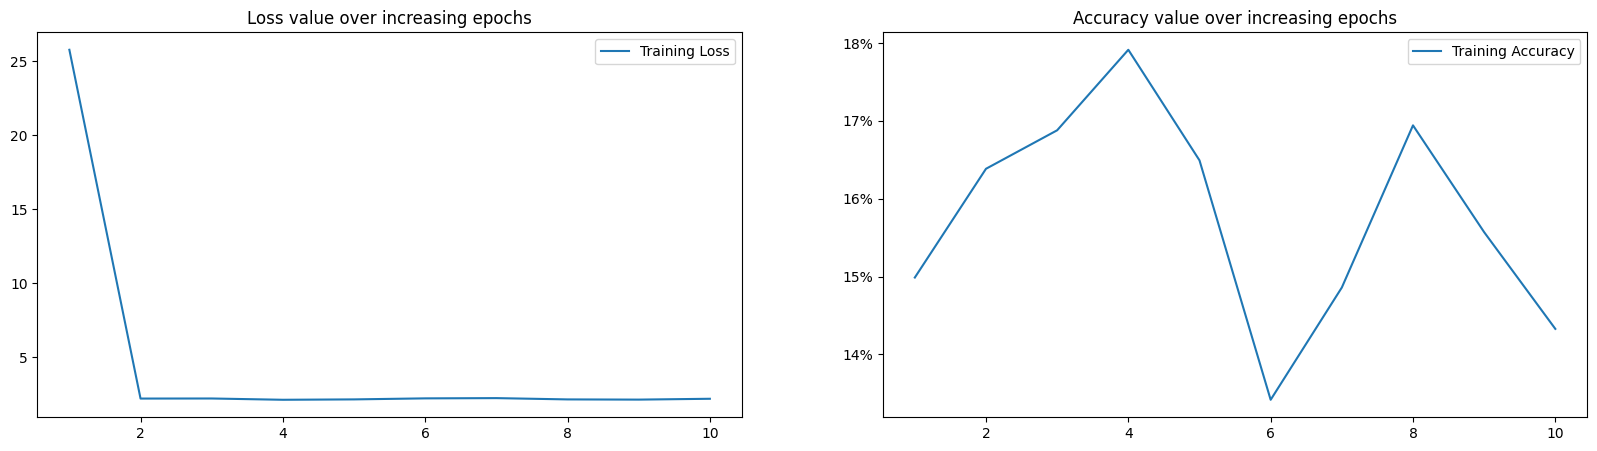

In [12]:
def display_loss_accuracy(number_epoch,lossses, accuracies):
    epochs = np.arange(number_epoch)+1
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Loss value over increasing epochs')
    plt.plot(epochs, lossses, label='Training Loss')
    plt.legend()
    plt.subplot(122)
    plt.title('Accuracy value over increasing epochs')
    plt.plot(epochs, accuracies, label='Training Accuracy')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.legend()

display_loss_accuracy(10,lossses, accuracies)

### 1.9 Results and Conclusion

 1. The training accuracy is not good enough at the end of ten epochs
 2. The loss value did not decrease considerably over the increasing numbers of epochs
 
 ##### so we will try to change the hyperparameters to see their impact on the training accuarcy and the loss value 